In [1]:
import jax3dp3 as j
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import io

intrinsics = j.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=1.0, far=500.0
)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
table_params = (1000.0,
    1000.0,
    0.01,
    0.01,
    0.01)
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
table_pose = j.t3d.inverse_pose(
    j.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 300.0, 150.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]

In [65]:
occluder = j.mesh.make_cuboid_mesh(jnp.array([10.0, 70.0, 100.0]))                       
obj_a = j.mesh.make_cuboid_mesh(jnp.array([50.0, 50.0, 50.0]))                       
obj_b = j.mesh.make_cuboid_mesh(jnp.array([50.0, 40.0, 50.0]))
obj_c = j.mesh.make_cuboid_mesh(jnp.array([50.0, 30.0, 50.0]))
renderer = j.Renderer(intrinsics, num_layers=1024)
renderer.add_mesh(occluder)
renderer.add_mesh(obj_a)
renderer.add_mesh(obj_b)
renderer.add_mesh(obj_c)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [66]:
def inference():
    all_hypotheses = []
    for obj_id in range(1,len(renderer.meshes)):
#         print("Object ID ", obj_id)
        contact_param = jnp.zeros(3)
        p = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
                contact_plane
            )
            POTENTIAL_R = jnp.hstack([jnp.tile(R[None,:], (R_SWEEP.shape[0], 1)),R_SWEEP])

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )
            reconstruction = renderer.render_multiobject_parallel(
                potential_poses, object_ids + [obj_id]
            )
            p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(
                observed_point_cloud_image,
                reconstruction[:,:,:,:3],
                reconstruction[:,:,:, -1],
                POTENTIAL_R, OUTLIER_PROBS, OUTLIER_VOLUME
            ).sum([-1,-2])
            
            ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]
    #         print(contact_param)
    #         print(POTENTIAL_R[jj])

        best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_PROBS[kk])

        all_hypotheses.append(
            (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
        )

    return all_hypotheses

In [132]:
sched = [(100.0, jnp.pi), (50.0, jnp.pi), (10.0, jnp.pi),
         (5.0, jnp.pi/2),(5.0, jnp.pi/2),(5.0, jnp.pi/2),
         (2.0, jnp.pi/2),(2.0, jnp.pi/2),(2.0, jnp.pi/2),
         (1.0, jnp.pi/4),(1.0, jnp.pi/4),(1.0, jnp.pi/4),
]

contact_param_gridding_schedule = [
    j.make_translation_grid_enumeration_3d(
        -x, 0.0, -y,
        x, 0.0, y,
        13,1,3
    )
    for (x,y) in sched
]

pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))


R_SWEEP = jnp.array([100.0, 50.0, 10.0, 5.0, 1.0]).reshape(-1,1)
print(R_SWEEP)
OUTLIER_PROBS = jnp.linspace(0.01, 0.1, 4)
OUTLIER_VOLUME = 100.0**3 * 0.001
SCALING_FACTOR = 3

[[100.]
 [ 50.]
 [ 10.]
 [  5.]
 [  1.]]


SCORES   [-91952.45 -91952.45 -91954.25]
NORMALIZED SCORES   [0.4614242  0.4614242  0.07651163]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]


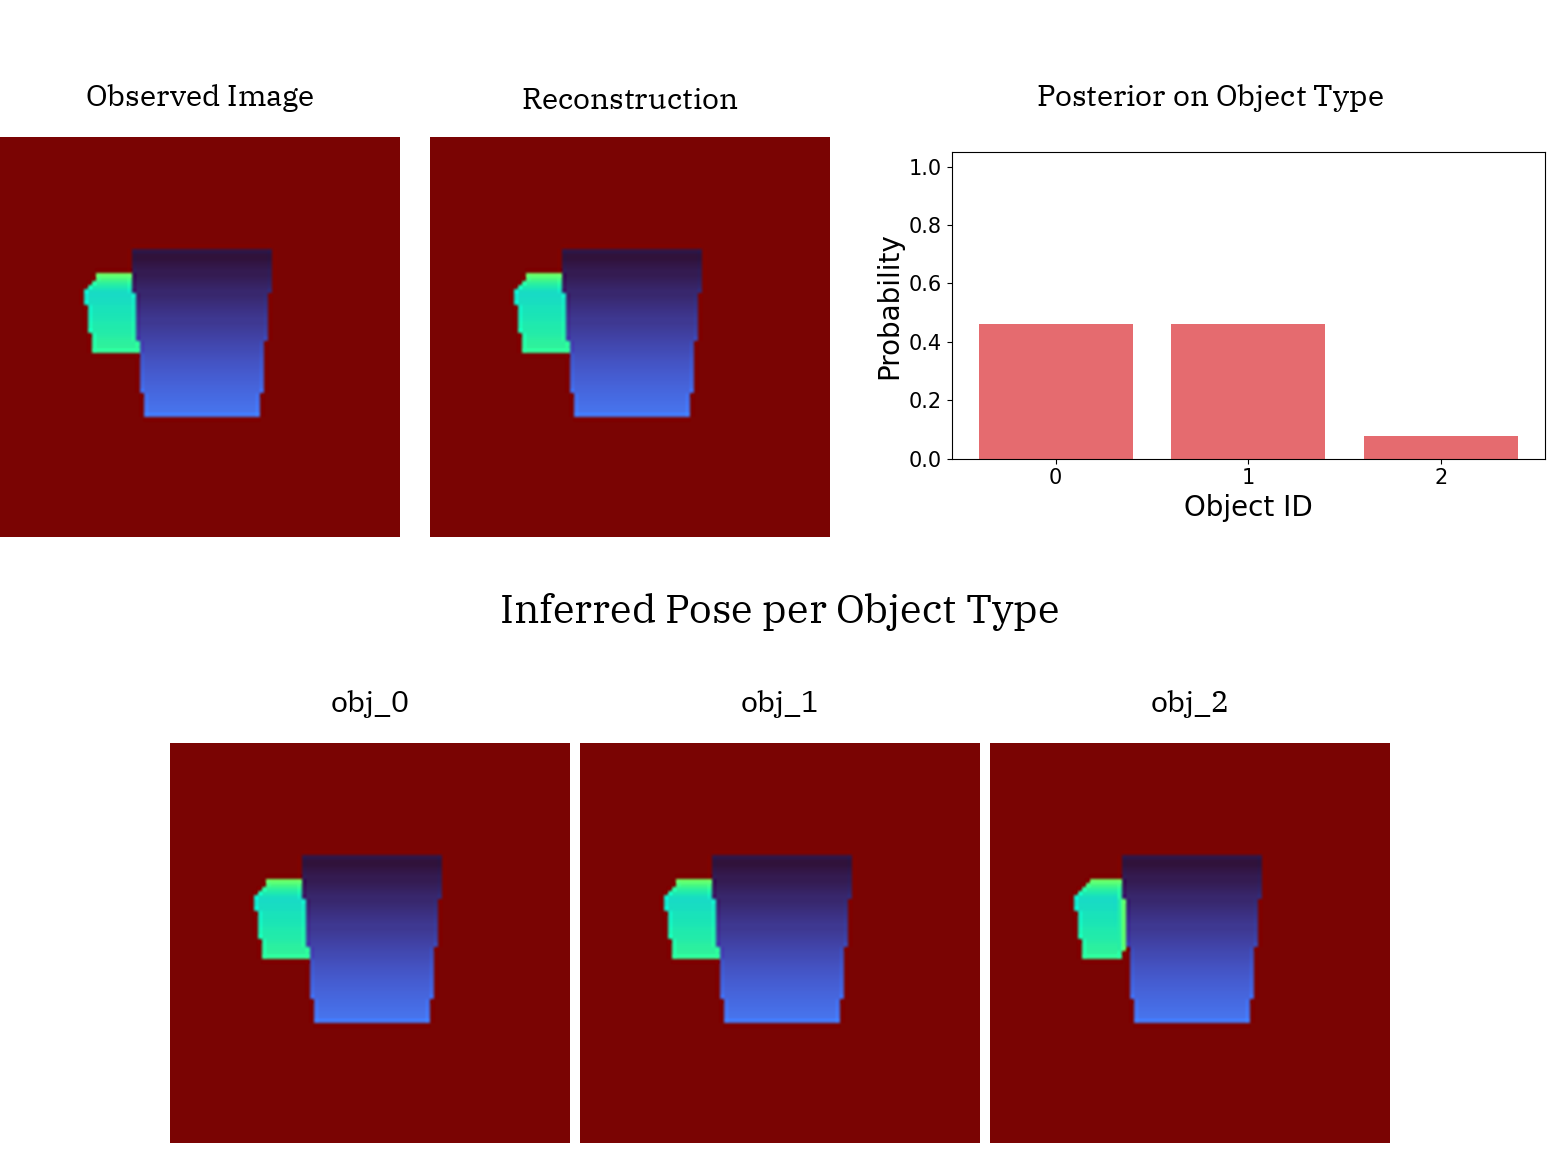

<Figure size 640x480 with 0 Axes>

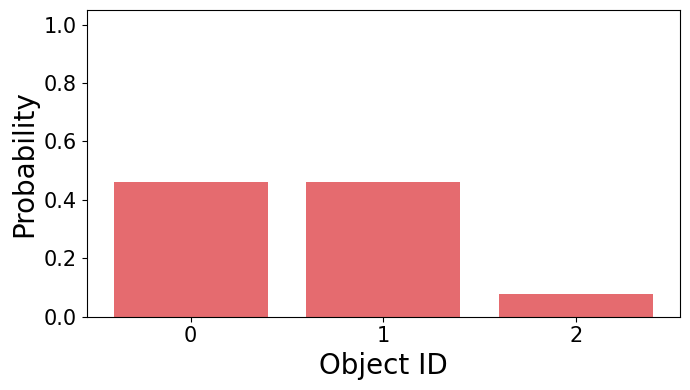

In [136]:
object_indices = jnp.array([0,1])

poses = j.scene_graph.pose_from_contact_and_face_params_multiobject_jit(
    jnp.array(
        [
            [0.0, 100.0, 0.0],
            [60.582275390625, 0.0, 0.0],
        ]
    ),
    jnp.array([3,3]),
    renderer.model_box_dims[object_indices],
    contact_plane
)
SCALING_FACTOR = 4
observed_point_cloud_image = renderer.render_multiobject(poses, object_indices)
j.meshcat.show_cloud("obs", observed_point_cloud_image[:,:,:3].reshape(-1,3) / 1000.0)
j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]),SCALING_FACTOR)

R = jnp.array([10.0, 1.0])
object_poses, object_ids = poses[:1,:,:][None,...], [object_indices[0]]
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)

all_hypotheses = inference()


scores = jnp.array([i[0] for i in all_hypotheses])
normalized_scores = j.utils.normalize_log_scores(scores)
print("SCORES  ", scores)
print("NORMALIZED SCORES  ", normalized_scores)
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

R = best_r
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]
print(object_ids)

# outliers = (
#     (1.0 - best_outlier_prob) * (j.gaussian_mixture_image_multi_r_jit(observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r))
#         <
#     (best_outlier_prob / OUTLIER_VOLUME)
# )

# height_factor = outlier_prob_viz.height / observed_image_viz.height
plt.clf()
plt.figure(figsize=(7,4))
color = np.array([229, 107, 111])/255.0
plt.bar(
    np.arange(len(normalized_scores)),
    normalized_scores,
    color=color
)
plt.xticks(np.arange(len(normalized_scores)), ["{:d}".format(i) for i in range(len(normalized_scores))],fontsize=15)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
plt.xlabel("Object ID",fontsize=20)
plt.ylabel("Probability",fontsize=20)
plt.ylim(0.0, 1.05)
plt.tight_layout()
img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')
posterior_bar_chart = Image.open(img_buf)

depth_viz = j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR)

height_factor = depth_viz.height / posterior_bar_chart.height



# outlier_viz = j.scale_image(j.get_depth_image(1.0 - outliers), SCALING_FACTOR)
viz1 = j.multi_panel(
    [
        depth_viz,
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(posterior_bar_chart, height_factor)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Posterior on Object Type",
    ],
    middle_width=30
)

viz2 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["obj_{:d}".format(idx, i.item()) for (idx,i) in enumerate(normalized_scores)],
    title="Inferred Pose per Object Type"
)

final_viz = j.vstack_images([viz1, viz2])
final_viz

x : -100.0
SCORES   [-91944.47  -91948.2   -91952.125]
NORMALIZED SCORES   [9.768350e-01 2.333473e-02 4.621193e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -97.46835
SCORES   [-91944.625 -91948.29  -91952.05 ]
NORMALIZED SCORES   [9.7683501e-01 2.5034511e-02 5.8417348e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -94.93671
SCORES   [-91944.92 -91948.53 -91952.23]
NORMALIZED SCORES   [9.692332e-01 2.623594e-02 6.516927e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -92.40506
SCORES   [-91945.11  -91948.78  -91954.766]
NORMALIZED SCORES   [9.768350e-01 2.483969e-02 6.254105e-05]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -89.87342
SCORES   [-91945.04  -91948.875 -91954.78 ]
NORMALIZED SCORES   [9.7683501e-01 2.1081172e-02 5.7390891e-05]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -87.34177
SCORES   [-91944.945 -91948.78  -91954.78 ]
NORMALIZED SCORES   [9.7683501e-01 2.1081172e-0

/tmp/ipykernel_12273/2898194730.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,4))


SCORES   [-91956.336 -91956.336 -91956.336]
NORMALIZED SCORES   [0.33235136 0.33235136 0.33235136]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -46.83545
SCORES   [-91957.17 -91957.17 -91957.17]
NORMALIZED SCORES   [0.33235136 0.33235136 0.33235136]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -44.303802
SCORES   [-91958.12 -91958.12 -91958.12]
NORMALIZED SCORES   [0.33235136 0.33235136 0.33235136]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -41.772156
SCORES   [-91959.016 -91959.016 -91959.016]
NORMALIZED SCORES   [0.33235136 0.33235136 0.33235136]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -39.24051
SCORES   [-91959.9 -91959.9 -91959.9]
NORMALIZED SCORES   [0.33235136 0.33235136 0.33235136]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : -36.708862
SCORES   [-91960.79 -91960.79 -91960.79]
NORMALIZED SCORES   [0.33235136 0.33235136 0.33235136]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype

SCORES   [-91947.58  -91950.875 -91954.58 ]
NORMALIZED SCORES   [9.6169060e-01 3.5581212e-02 8.7694830e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : 77.215195
SCORES   [-91946.94 -91950.94 -91954.64]
NORMALIZED SCORES   [9.8449647e-01 1.8031681e-02 4.4441578e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : 79.74683
SCORES   [-91946.34  -91949.945 -91953.7  ]
NORMALIZED SCORES   [9.6923321e-01 2.6441714e-02 6.1701017e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : 82.27848
SCORES   [-91945.57 -91951.08 -91954.7 ]
NORMALIZED SCORES   [9.922179e-01 4.023412e-03 1.072203e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : 84.81012
SCORES   [-91945.05  -91948.766 -91952.586]
NORMALIZED SCORES   [9.7683501e-01 2.3702197e-02 5.1957468e-04]
[0 1 2]
Best
[10.  1.  1.] 0.1 1
[Array(0, dtype=int32), 1]
x : 87.34177
SCORES   [-91944.945 -91948.78  -91954.77 ]
NORMALIZED SCORES   [9.7683501e-01 2.1081172e-02 5.2664840e

<Figure size 640x480 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

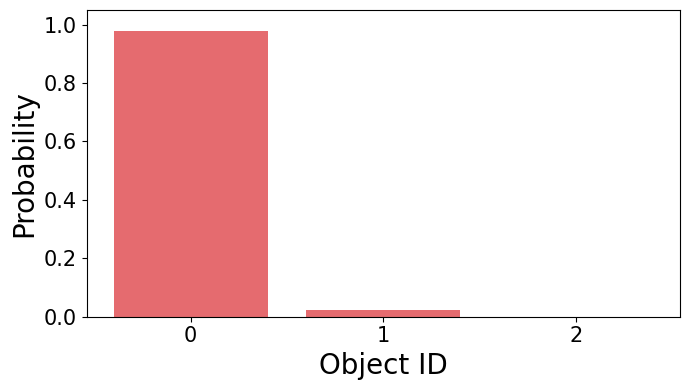

In [137]:
viz_images = []
for block_x in jnp.linspace(-100.0, 100.0, 80):
    print("x :", block_x)
    object_indices = jnp.array([0,1])

    poses = j.scene_graph.pose_from_contact_and_face_params_multiobject_jit(
        jnp.array(
            [
                [0.0, 100.0, 0.0],
                [block_x, 0.0, 0.0],
            ]
        ),
        jnp.array([3,3]),
        renderer.model_box_dims[object_indices],
        contact_plane
    )
    SCALING_FACTOR = 4
    observed_point_cloud_image = renderer.render_multiobject(poses, object_indices)
    j.meshcat.show_cloud("obs", observed_point_cloud_image[:,:,:3].reshape(-1,3) / 1000.0)
    j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]),SCALING_FACTOR)


    R = jnp.array([10.0, 1.0])
    object_poses, object_ids = poses[:1,:,:][None,...], [object_indices[0]]
    reconstruction = renderer.render_multiobject(
        object_poses, object_ids
    )

    all_hypotheses = inference()


    scores = jnp.array([i[0] for i in all_hypotheses])
    normalized_scores = j.utils.normalize_log_scores(scores)
    print("SCORES  ", scores)
    print("NORMALIZED SCORES  ", normalized_scores)
    print(jnp.argsort(-scores))
    best_hypothesis = all_hypotheses[jnp.argmax(scores)]
    score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
    print("Best")
    print(best_r, best_outlier_prob, obj_id)

    R = best_r
    object_poses = best_poses[:,None,...]
    object_ids = object_ids + [obj_id]
    print(object_ids)

    # outliers = (
    #     (1.0 - best_outlier_prob) * (j.gaussian_mixture_image_multi_r_jit(observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r))
    #         <
    #     (best_outlier_prob / OUTLIER_VOLUME)
    # )

    # height_factor = outlier_prob_viz.height / observed_image_viz.height
    plt.clf()
    plt.figure(figsize=(7,4))
    color = np.array([229, 107, 111])/255.0
    plt.bar(
        np.arange(len(normalized_scores)),
        normalized_scores,
        color=color
    )
    plt.xticks(np.arange(len(normalized_scores)), ["{:d}".format(i) for i in range(len(normalized_scores))],fontsize=15)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.xlabel("Object ID",fontsize=20)
    plt.ylabel("Probability",fontsize=20)
    plt.ylim(0.0, 1.05)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    posterior_bar_chart = Image.open(img_buf)

    depth_viz = j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR)

    height_factor = depth_viz.height / posterior_bar_chart.height



    # outlier_viz = j.scale_image(j.get_depth_image(1.0 - outliers), SCALING_FACTOR)
    viz1 = j.multi_panel(
        [
            depth_viz,
            j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
            j.scale_image(posterior_bar_chart, height_factor)
        ],
        labels=[
            "Observed Image",
            "Reconstruction",
            "Posterior on Object Type",
        ],
        middle_width=30
    )

    viz2 = j.multi_panel(
        [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
        labels=["obj_{:d}".format(idx, i.item()) for (idx,i) in enumerate(normalized_scores)],
        title="Inferred Pose per Object Type"
    )

    final_viz = j.vstack_images([viz1, viz2])
    viz_images.append(final_viz)


In [138]:
j.make_gif(viz_images, "out.gif")

[1.e-07 1.e-06 5.e+00]


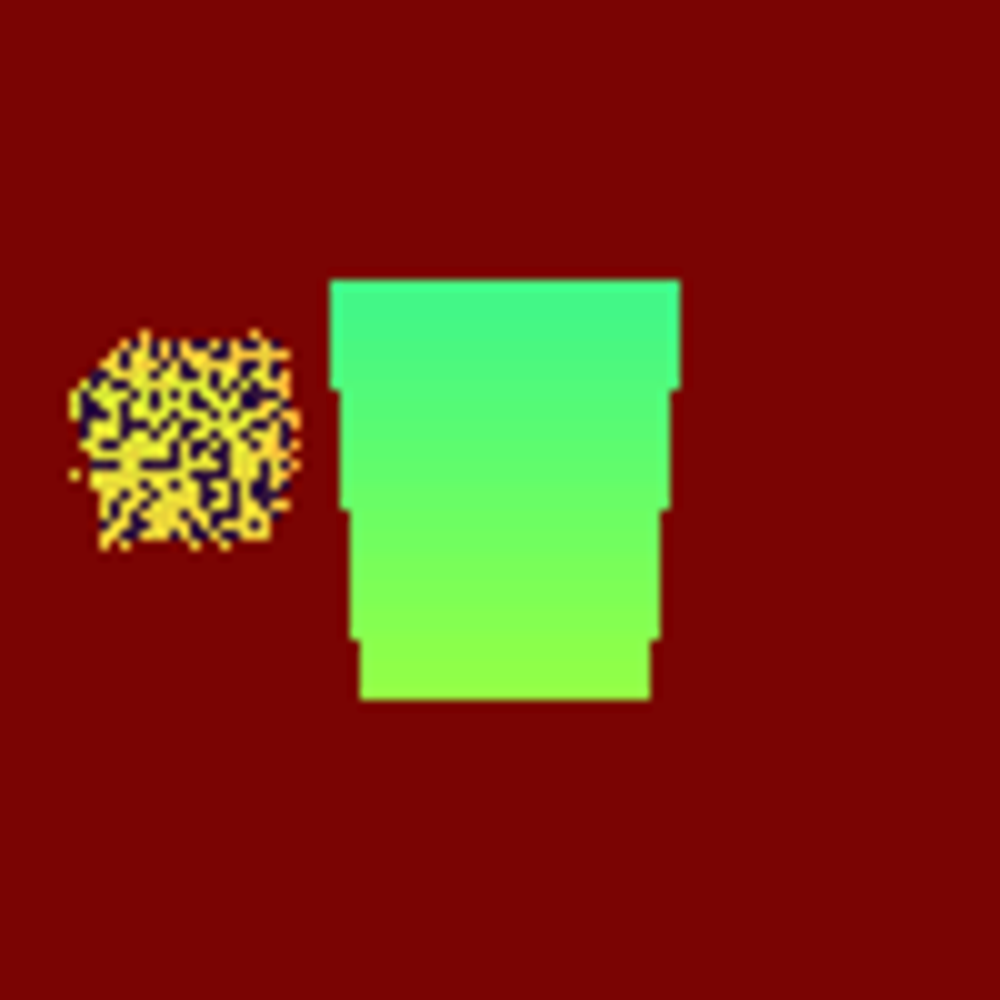

In [75]:
R = jnp.array([0.0000001, 0.000001, 5.0])
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)

# reconstruction = observed_point_cloud_image
rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])
r_array = R
print(r_array, )
r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
key = jax.random.PRNGKey(10)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)